In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Sun Jun 26 01:17:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 45%   56C    P2    67W / 260W |   7437MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# LDA

## 2019 brief paragraph

In [3]:
file_de = open("../LDA/segment/data/de_file_brief_paragraph_2019.txt", "r")
de_lines = file_de.readlines()

In [4]:
de_desc = [i.replace(" \n","").split(" ") for i in de_lines]

In [5]:
id2word = corpora.Dictionary(de_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(3809 unique tokens: ['aktualisierten', 'aktualisierter', 'au', 'auswhlen', 'basierend']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in de_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 7), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 3)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-7.617678,2033.834151
1,3,-7.595020,1988.269147
2,4,-7.578282,1955.266351
3,5,-7.555562,1911.343448
4,6,-7.546345,1893.807709
5,7,-7.536594,1875.431159
6,8,-7.523488,1851.011959
7,9,-7.529316,1861.832427
8,10,-7.519220,1843.129758
9,11,-7.509582,1825.449727


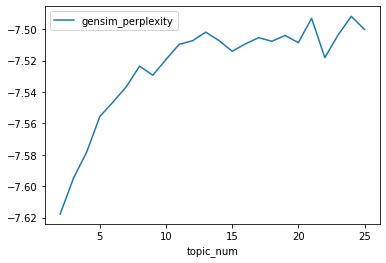

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.617678,2033.834151
1,3,-7.595020,1988.269147
2,4,-7.578282,1955.266351
3,5,-7.555562,1911.343448
4,6,-7.546345,1893.807709
5,7,-7.536594,1875.431159
6,8,-7.523488,1851.011959
7,9,-7.529316,1861.832427
8,10,-7.519220,1843.129758
9,11,-7.509582,1825.449727


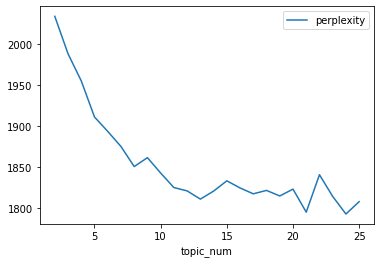

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_de_brief_paragraph_2019.csv", index=False)

## priority description sentence

In [11]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

16

In [23]:
topics_de = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_de.append(c.index(max(c)))

In [24]:
topics_de

[16,
 22,
 14,
 9,
 8,
 22,
 8,
 1,
 16,
 1,
 3,
 20,
 5,
 8,
 3,
 22,
 9,
 12,
 23,
 0,
 19,
 4,
 1,
 8,
 1,
 22,
 17,
 19,
 18,
 10,
 22,
 4,
 16,
 21,
 21,
 6,
 12,
 18,
 8,
 22,
 9,
 12,
 6,
 10,
 17,
 4,
 15,
 8,
 0,
 12,
 3,
 18,
 22,
 20,
 0,
 5,
 3,
 21,
 4,
 12,
 22,
 14,
 2,
 0,
 8,
 8,
 6,
 2,
 2,
 20,
 2,
 8,
 5,
 2,
 8,
 21,
 4,
 20,
 15,
 17,
 0,
 11,
 17,
 2,
 2,
 5,
 8,
 6,
 22,
 23,
 9,
 5,
 13,
 8,
 8,
 8,
 9,
 1,
 1,
 21,
 10,
 8,
 8,
 15,
 15,
 8,
 19,
 19,
 21,
 11,
 5,
 7,
 4,
 9,
 8,
 4,
 1,
 11,
 9,
 18,
 2,
 3,
 1,
 19,
 22,
 8,
 2,
 3,
 21,
 12,
 5,
 19,
 16,
 6,
 16,
 22,
 5,
 23,
 19,
 6,
 4,
 23,
 22,
 9,
 8,
 0,
 15,
 13,
 4,
 13,
 2,
 15,
 0,
 4,
 4,
 16,
 8,
 6,
 0,
 8,
 0,
 4,
 22,
 19,
 4,
 4,
 8,
 18,
 6,
 12,
 22,
 5,
 22,
 8,
 4,
 1,
 19,
 4,
 12,
 4,
 4,
 1,
 21,
 14,
 16,
 5,
 11,
 3,
 16,
 8,
 8,
 9,
 3,
 7,
 17,
 15,
 3,
 23,
 19,
 1,
 8,
 19,
 13,
 1,
 2,
 19,
 4,
 16,
 12,
 4,
 14,
 10,
 2,
 11,
 6,
 10,
 1,
 1,
 18,
 4,
 15,
 4,
 9,
 5,
 15,


In [25]:
print(len(topics_de))
print(len(de_desc))

242
242


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2019 = db.rm_patent_us_2019
    # db_rm_us_2019 = db.rm_patent_us_2019
    db_rm_de_2019 = db.rm_patent_de_2019
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_de_desc = db_rm_de_2019.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_de_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_de = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_de

,id,patentNumber,company,brief
0,61fc36205eb7331c4068c24c,DE112019001144T5,[],Ein Beispiel beinhaltet das Senden erster Gewi...
1,61fc363f5eb7331c4068c258,DE102019105464A1,[Apiform GmbH],Die Erfindung betrifft ein Organisationssystem...
2,61fc36cc5eb7331c4068c280,DE112019005831T5,[],"Ein Neuronennetzmodell wird trainiert, wobei d..."
3,61fc37af5eb7331c4068c290,DE102019112380A1,[Intel Corp],Hier werden Techniken in Bezug auf ein Verfahr...
4,61fc37cc5eb7331c4068c294,DE202019005740U1,[Samsung Electronics Co Ltd],"Elektronische Vorrichtung, aufweisend:ein erst..."
...,...,...,...,...
237,61fc459b5eb7331c4068ca80,DE102019216038A1,[Festool GmbH],Die Erfindung betrifft ein Assistenzgerät (3) ...
238,61fc45a95eb7331c4068ca84,DE102019203765A1,[GlobalFoundries US Inc],"Verfahren, Vorrichtungen und Systeme zum Bilde..."
239,61fc45ac5eb7331c4068ca8a,DE102019007710B3,[Diehl AKO Stiftung and Co KG],Ein Wäschetrocknungssystem ohne Wäschetrockner...
240,61fc45ae5eb7331c4068ca8c,DE102019220053A1,[Residential Iot Services GmbH],Ein Verfahren umfasst Schritte des Bestimmens ...


In [30]:
print(len(df_de))
print(len(de_desc))

242
242


In [31]:
df_de["topic"]=topics_de

In [32]:
df_de

,id,patentNumber,company,brief,topic
0,61fc36205eb7331c4068c24c,DE112019001144T5,[],Ein Beispiel beinhaltet das Senden erster Gewi...,16
1,61fc363f5eb7331c4068c258,DE102019105464A1,[Apiform GmbH],Die Erfindung betrifft ein Organisationssystem...,22
2,61fc36cc5eb7331c4068c280,DE112019005831T5,[],"Ein Neuronennetzmodell wird trainiert, wobei d...",14
3,61fc37af5eb7331c4068c290,DE102019112380A1,[Intel Corp],Hier werden Techniken in Bezug auf ein Verfahr...,9
4,61fc37cc5eb7331c4068c294,DE202019005740U1,[Samsung Electronics Co Ltd],"Elektronische Vorrichtung, aufweisend:ein erst...",8
...,...,...,...,...,...
237,61fc459b5eb7331c4068ca80,DE102019216038A1,[Festool GmbH],Die Erfindung betrifft ein Assistenzgerät (3) ...,8
238,61fc45a95eb7331c4068ca84,DE102019203765A1,[GlobalFoundries US Inc],"Verfahren, Vorrichtungen und Systeme zum Bilde...",8
239,61fc45ac5eb7331c4068ca8a,DE102019007710B3,[Diehl AKO Stiftung and Co KG],Ein Wäschetrocknungssystem ohne Wäschetrockner...,19
240,61fc45ae5eb7331c4068ca8c,DE102019220053A1,[Residential Iot Services GmbH],Ein Verfahren umfasst Schritte des Bestimmens ...,0


In [33]:
df_de2 = df_de.explode('company')
df_de2

,id,patentNumber,company,brief,topic
0,61fc36205eb7331c4068c24c,DE112019001144T5,NaN,Ein Beispiel beinhaltet das Senden erster Gewi...,16
1,61fc363f5eb7331c4068c258,DE102019105464A1,Apiform GmbH,Die Erfindung betrifft ein Organisationssystem...,22
2,61fc36cc5eb7331c4068c280,DE112019005831T5,NaN,"Ein Neuronennetzmodell wird trainiert, wobei d...",14
3,61fc37af5eb7331c4068c290,DE102019112380A1,Intel Corp,Hier werden Techniken in Bezug auf ein Verfahr...,9
4,61fc37cc5eb7331c4068c294,DE202019005740U1,Samsung Electronics Co Ltd,"Elektronische Vorrichtung, aufweisend:ein erst...",8
...,...,...,...,...,...
237,61fc459b5eb7331c4068ca80,DE102019216038A1,Festool GmbH,Die Erfindung betrifft ein Assistenzgerät (3) ...,8
238,61fc45a95eb7331c4068ca84,DE102019203765A1,GlobalFoundries US Inc,"Verfahren, Vorrichtungen und Systeme zum Bilde...",8
239,61fc45ac5eb7331c4068ca8a,DE102019007710B3,Diehl AKO Stiftung and Co KG,Ein Wäschetrocknungssystem ohne Wäschetrockner...,19
240,61fc45ae5eb7331c4068ca8c,DE102019220053A1,Residential Iot Services GmbH,Ein Verfahren umfasst Schritte des Bestimmens ...,0


In [34]:
# 排名前16的公司
c_ls = list(df_de2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Samsung Electronics Co Ltd',
 'Intel Corp',
 'LG Electronics Inc',
 'Sony Corp',
 'Siemens AG',
 'Fraunhofer Gesellschaft zur Forderung der Angewandten Forschung eV',
 'Sony Group Corp',
 'NEC Corp',
 'Sony Semiconductor Solutions Corp',
 'Siemens Energy Global GmbH and Co KG',
 'Robert Bosch GmbH',
 'Hyundai Motor Co',
 'Siemens Mobility GmbH',
 'Kia Corp',
 'Bayerische Motoren Werke AG',
 'IFM Electronic GmbH']

### 轉成company-topic 的總數表格

In [35]:
df_de_count = df_de2.groupby(["company","topic"],as_index=False).size()
df_de_count

,company,topic,size
0,Accell Group NV,1,1
1,Adobe Inc,6,1
2,Amer Sports Digital Services Oy,4,1
3,Amer Sports Digital Services Oy,22,1
4,Analog Devices Global ULC,10,1
...,...,...,...
229,Wind Mobility Tech Beijing Co Ltd,1,1
230,Wind Mobility Technology (beijing) Co Ltd,1,1
231,ZF Friedrichshafen AG,3,1
232,ZF Friedrichshafen AG,23,1


In [36]:
# 轉成company-topic 的總數表格
table_de = df_de_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_de = table_de.droplevel(level=0, axis=1)
table_de = table_de.rename(columns={'':'company'})

In [37]:
table_de

topic,company,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,Accell Group NV,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adobe Inc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Amer Sports Digital Services Oy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Analog Devices Global ULC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Apiform GmbH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Werma Holding Co KG GmbH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
132,Wind Mobility Tech Beijing Co Ltd,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133,Wind Mobility Technology (beijing) Co Ltd,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,ZF Friedrichshafen AG,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
final_table_de = table_de[table_de.company.isin(c_ls)]
final_table_de

topic,company,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
8,Bayerische Motoren Werke AG,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,Fraunhofer Gesellschaft zur Forderung der Ange...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
51,Hyundai Motor Co,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52,IFM Electronic GmbH,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,Intel Corp,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,2.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0
71,Kia Corp,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
76,LG Electronics Inc,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0
86,NEC Corp,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,Robert Bosch GmbH,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,Samsung Electronics Co Ltd,1.0,3.0,0.0,0.0,5.0,0.0,1.0,0.0,3.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [39]:
final_table_de.shape

(16, 25)

In [40]:
table_de.to_csv('company_lda_brief_de_2019.csv',index=0)